In [1]:
import mdtraj as md
import pyemma.coordinates as coor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gro = md.load('frame0_nw.gro')

In [3]:
traj = md.load('7oft_50mm_whole_wrap.trr', top=gro.top)

In [4]:
lig = gro.top.select('resname == hba')
# 44 * 15
lig_idx = np.arange(0,660,15)

In [5]:
traj.superpose(gro, atom_indices=gro.top.select('backbone'))

<mdtraj.Trajectory with 30002 frames, 5872 atoms, 622 residues, and unitcells at 0x7ffad5b4fa30>

In [6]:
com_list = [0] * 44

for i in range(len(lig_idx)):
    small_traj = traj.atom_slice(lig[lig_idx[i]:lig_idx[i]+15])
    com_list[i] = md.compute_center_of_mass(small_traj)

In [7]:
import sklearn
from sklearn.cluster import DBSCAN

In [8]:
com_cat = np.concatenate(com_list)

In [9]:
cl = DBSCAN(eps=0.15, min_samples=6500).fit(com_cat)

In [10]:
len(set(cl.labels_))

4

In [11]:
def write_com_to_gro(com, file_name):
    ''' write center of mass point to gro file to open in VMD, chimera, or similiar'''
    with open(file_name, 'w') as f:
        f.write('Protein in water\n')
        f.write(' 1\n')
        f.write(f'    1GLU      N    1   {np.round(com[0], 3)}   {np.round(com[1], 3)}   {np.round(com[2], 3)}\n')
        f.write('  11.27360  11.27360  11.27360\n')

In [12]:
cluster_list = []
avg_list = []

for i in set(cl.labels_):
    if i == -1:
        continue
    cluster_list.append(com_cat[cl.labels_ == i])
    print(i, cluster_list[i].shape[0])
    avg_list.append(cluster_list[i].mean(axis=0))

0 8040
1 12166
2 8135


In [18]:
for i in range(3):
    write_com_to_gro(avg_list[i], f'cluster/7oft_50mm_cluster{i}.gro')

In [14]:
crystal = md.load('../../true_7oft.pdb')

In [15]:
cry_idx = crystal.top.select('resname == hba')
lig_rmsds = [0] * 44

In [16]:
def manual_rmsd(a,b):
    result = np.ndarray((a.shape[0],1), dtype='float32')
    N = b.shape[1]
    for i in range(a.shape[0]):
        result[i] = np.sqrt(np.sum((a[i] - b[0]) ** 2) / N)
    return result

def ex_rmsd(traj, ref, ref_frame=0, atom_indices_traj=None, atom_indices_ref=None, alignment_indices=None):
    'align to protein then take rmsd of ligand'
    traj.superpose(ref, frame=ref_frame, atom_indices=alignment_indices, parallel=True)
    small_traj = traj.atom_slice(atom_indices_traj)
    small_ref = ref.atom_slice(atom_indices_ref)
    f = manual_rmsd(small_traj.xyz, small_ref.xyz)
    return f

In [17]:
for i in range(len(lig_idx)):
    lig_rmsds[i] = ex_rmsd(traj, crystal, atom_indices_traj=lig[lig_idx[i]:lig_idx[i]+15], atom_indices_ref=cry_idx, alignment_indices=gro.top.select('backbone'))

In [19]:
time = np.arange(0, 300.02, 0.01)

In [20]:
lig_rmsds2 = lig_rmsds[:-1]
under_5_list = [0] * 44
for i in range(len(lig_rmsds2)):
    under_5_list[i] = (lig_rmsds2[i] < 0.5).sum()

In [21]:
for i in range(len(under_5_list)):
    print(i, under_5_list[i])

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 12076
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 2
30 0
31 1
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0


Text(0, 0.5, 'Ligand RMSD (nm)')

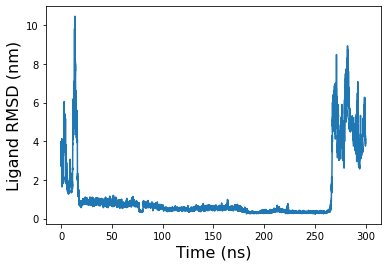

In [23]:
plt.plot(time, lig_rmsds[20])
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Ligand RMSD (nm)', fontsize=16)

In [24]:
np.save('lowest_lig_rmsd.npy', lig_rmsds[20])

In [25]:
lig_rmsds[20].min()

0.24084598

In [7]:
# contact analysis

In [10]:
sites = 3
site_list = [md.load(f'cluster/7oft_50mm_cluster{i}.gro') for i in range(sites)]

In [11]:
def calc_eu_dist(a,b):
    '''calculate the euclidean distance between two cartesian coordinate points'''
    dist = np.sqrt(np.sum((a - b) ** 2))
    return dist

In [12]:
def slice_spots(traj, sites, com_list, site_list, gro, lig, lig_idx, lig_atoms=20):
    '''takes trajectoy and retures seperate trajectories where ligands are in spots'''
    out_list3 = [0] * sites

    for i in range(sites):
        counter = 0
        for j in range(len(com_list)):
            #for k in range(traj.n_frames):
            d = [calc_eu_dist(l, site_list[i].xyz[0][0]) for l in com_list[j]]
            b = np.array(d)
            idx = np.where(b < 0.15)[0]
            if counter == 0:
                temp = traj[idx]
                temp2 = temp.atom_slice(np.concatenate((gro.top.select('protein'), lig[lig_idx[j]:lig_idx[j]+lig_atoms])))
                out_list3[i] = temp2
                counter = 1
            else:
                temp = traj[idx]                      
                temp2 = temp.atom_slice(np.concatenate((gro.top.select('protein'), lig[lig_idx[j]:lig_idx[j]+lig_atoms])))
                out_list3[i] = out_list3[i].join(temp2)
                
    return out_list3

In [13]:
out_list = slice_spots(traj, sites, com_list, site_list, gro, lig, lig_idx, lig_atoms=15)

In [14]:
out_list[0].save('sitetraj_cl0_B_s4.xtc')

In [15]:
out_list[1].save('sitetraj_cl1_G_s10.xtc')

In [16]:
out_list[2].save('sitetraj_cl2_K_s9.xtc')

In [17]:
start = out_list[0][0]

In [18]:
start.save('s4_frame0.gro')

In [19]:
new_lig = start.top.select('resname == hba and not name H')

In [20]:
res = np.zeros((315,2))
for i in range(315):
    res[i,0] = i
for i in range(315):
    res[i,1] = 315

In [21]:
def average_contacts(gro, traj_name, threshold):
    feat = coor.featurizer(gro)
    feat.add_residue_mindist(residue_pairs=res, threshold=threshold)
    min_dis = coor.load(traj_name, features=feat)
    mean = np.mean(min_dis.sum(axis=1))
    return mean

In [22]:
average_contacts(start, 'sitetraj_cl0_B_s4.xtc', 0.35)

3.0563147

In [23]:
average_contacts(start, 'sitetraj_cl0_B_s4.xtc', 0.4)

5.9680133

In [24]:
average_contacts(start, 'sitetraj_cl1_G_s10.xtc', 0.35)

2.7725205

In [25]:
average_contacts(start, 'sitetraj_cl1_G_s10.xtc', 0.4)

5.9262967

In [26]:
average_contacts(start, 'sitetraj_cl2_K_s9.xtc', 0.35)

4.963369

In [27]:
average_contacts(start, 'sitetraj_cl2_K_s9.xtc', 0.4)

9.3973875